# Boston Airbnb Listings Analysis

## For details on how to run the file refer the Project Report, particularly the **How to Run** section

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
from pyspark.sql import types as T
from textblob import TextBlob

In [2]:
spark = SparkSession\
        .builder\
        .master("local")\
        .config("spark.files.overwrite", True)\
        .getOrCreate()

## Let's Start by analyzing the boston neighbourhoods that are present in the Airbnb website

In [3]:
boston_neighbourhoods_df = spark.read.csv("data/Boston/2020/June/neighbourhoods.csv", header=True)
boston_neighbourhoods_df.toPandas()

,neighbourhood_group,neighbourhood
0,None,Allston
1,None,Back Bay
2,None,Bay Village
3,None,Beacon Hill
4,None,Brighton
5,None,Charlestown
6,None,Chinatown
7,None,Dorchester
8,None,Downtown
9,None,East Boston


### We can see that for Boston atleast, there are no neighbourhood_groups, so lets drop the column

In [4]:
boston_neighbourhoods_df = boston_neighbourhoods_df.drop('neighbourhood_group')
boston_neighbourhoods_df.toPandas()

,neighbourhood
0,Allston
1,Back Bay
2,Bay Village
3,Beacon Hill
4,Brighton
5,Charlestown
6,Chinatown
7,Dorchester
8,Downtown
9,East Boston


## We will be running the analysis only on the top neighbourhoods that we selected from "http://insideairbnb.com/get-the-data.html" ,which had the highest YoY percent change.

In [5]:
neighbourhoods_list = ["Back Bay", 'South Boston', 'South End', 'Fenway', 'Allston', 'Dorchester', 'Downtown']
boston_neighbourhoods_df = spark.createDataFrame(neighbourhoods_list, StringType())
boston_neighbourhoods_df = boston_neighbourhoods_df.selectExpr("value as neighbourhood")
boston_neighbourhoods_df.createOrReplaceTempView('boston_neighbourhoods')
boston_neighbourhoods_df.toPandas()

,neighbourhood
0,Back Bay
1,South Boston
2,South End
3,Fenway
4,Allston
5,Dorchester
6,Downtown


### Let's create a function to read in listings data, and provide neighbourhood data such as number of listings for a particular year and average price for a year

In [6]:
def neighbourhood_data_analysis_summary(file_path, year):
    boston_listings_df = spark.read.csv(file_path, header=True)
    boston_listings_df.createOrReplaceTempView('boston_listings')
    boston_listings_df = spark.sql("""
        SELECT * FROM boston_listings L
        WHERE L.neighbourhood IN 
        (SELECT neighbourhood FROM boston_neighbourhoods)
    """)
    boston_listings_df.createOrReplaceTempView('boston_listings')
    neighbourhood_data = spark.sql("""
        SELECT neighbourhood, count(neighbourhood) as number_of_listings, ROUND(avg(price), 2) as average_price
        FROM boston_listings
        GROUP BY neighbourhood
        ORDER BY number_of_listings desc
    """)
    return neighbourhood_data.withColumn("year", F.lit(year))
    

### 2020: 

In [7]:
neighbourhood_data_2020 = neighbourhood_data_analysis_summary("data/Boston/2020/June/listings_original.csv", 2020)
neighbourhood_data_2020.toPandas()

,neighbourhood,number_of_listings,average_price,year
0,Dorchester,420,159.15,2020
1,Downtown,277,304.44,2020
2,Back Bay,224,259.63,2020
3,South End,214,171.21,2020
4,Allston,197,107.50,2020
5,South Boston,168,191.32,2020
6,Fenway,167,224.37,2020


### 2019: 

In [8]:
neighbourhood_data_2019 = neighbourhood_data_analysis_summary("data/Boston/2019/June/listings.csv", 2019)
neighbourhood_data_2019.toPandas()

,neighbourhood,number_of_listings,average_price,year
0,Dorchester,558,107.04,2019
1,Downtown,498,264.05,2019
2,Back Bay,471,332.59,2019
3,South End,404,227.28,2019
4,Fenway,400,235.58,2019
5,Allston,338,181.63,2019
6,South Boston,333,225.68,2019


### 2018:

In [9]:
neighbourhood_data_2018 = neighbourhood_data_analysis_summary("data/Boston/2018/July/listings.csv", 2018)
neighbourhood_data_2018.toPandas()

,neighbourhood,number_of_listings,average_price,year
0,Dorchester,519,99.11,2018
1,Fenway,498,237.59,2018
2,Back Bay,464,248.84,2018
3,South End,406,212.26,2018
4,Allston,393,156.82,2018
5,Downtown,361,252.73,2018
6,South Boston,312,211.29,2018


### 2017

In [10]:
neighbourhood_data_2017 = neighbourhood_data_analysis_summary("data/Boston/2017/October/listings.csv", 2017)
neighbourhood_data_2017.toPandas()

,neighbourhood,number_of_listings,average_price,year
0,Back Bay,410,239.88,2017
1,Dorchester,398,98.26,2017
2,Fenway,357,210.86,2017
3,South End,354,214.52,2017
4,Allston,297,99.63,2017
5,Downtown,295,252.32,2017
6,South Boston,264,197.83,2017


### 2016

In [11]:
neighbourhood_data_2016 = neighbourhood_data_analysis_summary("data/Boston/2016/September/listings.csv", 2016)
neighbourhood_data_2016.toPandas()

,neighbourhood,number_of_listings,average_price,year
0,South End,326,204.35,2016
1,Back Bay,302,240.95,2016
2,Fenway,290,220.39,2016
3,Dorchester,269,91.64,2016
4,Allston,260,112.31,2016
5,South Boston,174,187.61,2016
6,Downtown,172,236.46,2016


### 2015

In [12]:
neighbourhood_data_2015 = neighbourhood_data_analysis_summary("data/Boston/2015/October/listings.csv", 2015)
neighbourhood_data_2015.toPandas()

,neighbourhood,number_of_listings,average_price,year
0,South End,251,216.96,2015
1,Allston,223,128.91,2015
2,Back Bay,206,248.80,2015
3,Fenway,185,249.91,2015
4,Dorchester,166,104.14,2015
5,South Boston,114,191.62,2015
6,Downtown,103,243.82,2015


### Let's combine all the dataframes

In [13]:
neighbourhood_data = neighbourhood_data_2020.union(neighbourhood_data_2019)
neighbourhood_data = neighbourhood_data.union(neighbourhood_data_2018)
neighbourhood_data = neighbourhood_data.union(neighbourhood_data_2017)
neighbourhood_data = neighbourhood_data.union(neighbourhood_data_2016)
neighbourhood_data = neighbourhood_data.union(neighbourhood_data_2015)

In [14]:
neighbourhood_data = neighbourhood_data.withColumn("number_of_listings", neighbourhood_data["number_of_listings"].cast(IntegerType()))
neighbourhood_data.toPandas()

,neighbourhood,number_of_listings,average_price,year
0,Dorchester,420,159.15,2020
1,Downtown,277,304.44,2020
2,Back Bay,224,259.63,2020
3,South End,214,171.21,2020
4,Allston,197,107.50,2020
5,South Boston,168,191.32,2020
6,Fenway,167,224.37,2020
7,Dorchester,558,107.04,2019
8,Downtown,498,264.05,2019
9,Back Bay,471,332.59,2019


## Lets visualize how the number of listings and average price has changed over the years in each of these neighbourhoods.

In [15]:
def format_data(neighbourhood, column_name):
    filter_cond = f"neighbourhood == '{neighbourhood}'".format(neighbourhood = neighbourhood)
    listings_neighbourhood[neighbourhood]= neighbourhood_data.where(filter_cond).select(column_name).toPandas()[column_name].tolist()

In [16]:
listings_neighbourhood={}
years=[2020,2019,2018,2017,2016,2015]

for neighbourhood in neighbourhoods_list :
    format_data(neighbourhood,'number_of_listings')

Text(0, 0.5, 'number_of_listings')

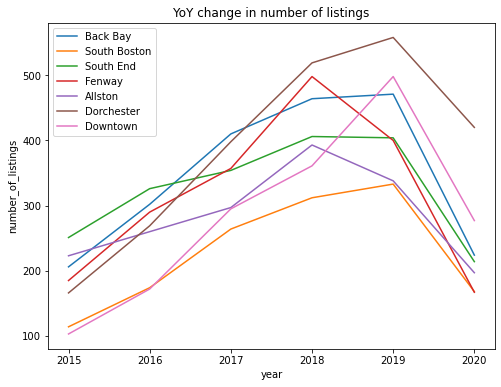

In [17]:
df = pd.DataFrame(listings_neighbourhood, index=years)
lines = df.plot.line(figsize=(8,6), title="YoY change in number of listings")
lines.set_xlabel("year")
lines.set_ylabel("number_of_listings")

1) We can notice in the above graph how the number of listings have increased over the years in each of these neighbourhoods

2) The dip in numbers from 2019 to 2020 is also highly noticeable, we are chalking this down to COVID-19 reasons

In [18]:
listings_neighbourhood={}
years=[2020,2019,2018,2017,2016,2015]

for neighbourhood in neighbourhoods_list :
    format_data(neighbourhood,'average_price')

Text(0, 0.5, 'average_price')

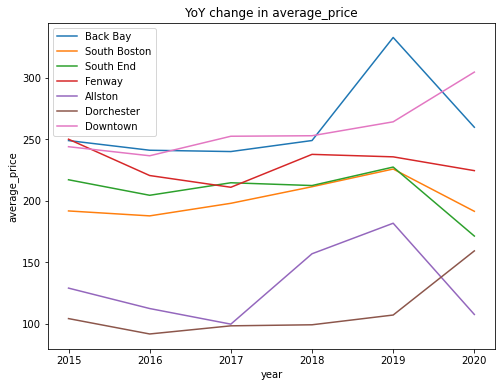

In [19]:
df = pd.DataFrame(listings_neighbourhood, index=years)
lines = df.plot.line(figsize=(8,6), title="YoY change in average_price")
lines.set_xlabel("year")
lines.set_ylabel("average_price")

1) Similar to number of listings in each of the neighbourhoods, the average price. of each of the neighbourhoods has also gone up over the years.

2) And similar to number of listings, we can see a sharp decline in price from 2019 to 2020, due to COVID-19 reasons

Now, we have seen how each of the neighbourhoods have grown throughout the years

But these neighbourhoods weren't thriving back in 2014, Fenway, Allston and Dorchester were considered to be the poorest neighbourhoods in Boston, according to a research done by Boston Redevelopment Authority, http://www.bostonplans.org/getattachment/f1ecaf8a-d529-40b6-a9bc-8b4419587b86

## Let's take a deeper dive into these neighbourhoods and see how Airbnb has helped gentrify these neighbourhoods

We have carried out few analysis on the above neighbourhoods here, but a deeper dive into the Airbnb reviews on these neighbourhoods can be found in **Boston_Aibnb_Analysis_Detailed.ipynb** notebook

For deeper dive into the neighbourhoods, let's create a neighbourhood_data_analysis_detailed function, that tweaks the summary function to include room_type analysis as well for each neighbourhood

In [84]:
def neighbourhood_data_analysis_detailed(file_path, neighbourhood, year):
    boston_listings_df = spark.read.csv(file_path, header=True)
    filter_cond = f"neighbourhood == '{neighbourhood}'".format(neighbourhood = neighbourhood)
    neighbourhood_data = boston_listings_df.where(filter_cond)
    neighbourhood_data.createOrReplaceTempView("neighbourhood")
    return spark.sql("""
        SELECT room_type, COUNT(room_type) as number_of_listings, ROUND(avg(price), 2) as average_price
        FROM neighbourhood
        GROUP BY room_type
        ORDER BY number_of_listings desc
    """).withColumn("year", F.lit(year))
    

### Lets use the above function to see how each room_type has been perceived and used by Airbnb hosts and its customers over the years

### Allston 

In [85]:
neighbourhood = "Allston"
allston_neighbourhood_2015 = neighbourhood_data_analysis_detailed("data/Boston/2015/October/listings.csv", neighbourhood, 2015)
allston_neighbourhood_2016 = neighbourhood_data_analysis_detailed("data/Boston/2016/September/listings.csv", neighbourhood, 2016)
allston_neighbourhood_2017 = neighbourhood_data_analysis_detailed("data/Boston/2017/October/listings.csv", neighbourhood, 2017)
allston_neighbourhood_2018 = neighbourhood_data_analysis_detailed("data/Boston/2018/July/listings.csv", neighbourhood, 2018)
allston_neighbourhood_2019 = neighbourhood_data_analysis_detailed("data/Boston/2019/June/listings.csv", neighbourhood, 2019)
allston_neighbourhood_2020 = neighbourhood_data_analysis_detailed("data/Boston/2020/June/listings_original.csv", neighbourhood, 2020)
allston_neighbourhood = allston_neighbourhood_2020.union(allston_neighbourhood_2019)
allston_neighbourhood = allston_neighbourhood.union(allston_neighbourhood_2018)
allston_neighbourhood = allston_neighbourhood.union(allston_neighbourhood_2017)
allston_neighbourhood = allston_neighbourhood.union(allston_neighbourhood_2016)
allston_neighbourhood = allston_neighbourhood.union(allston_neighbourhood_2015)
allston_neighbourhood.toPandas()


,room_type,number_of_listings,average_price,year
0,Private room,104,69.92,2020
1,Entire home/apt,92,150.82,2020
2,Shared room,1,30.00,2020
3,Private room,185,125.95,2019
4,Entire home/apt,150,253.15,2019
5,Shared room,3,39.33,2019
6,Private room,224,65.62,2018
7,Entire home/apt,161,289.35,2018
8,Shared room,8,43.38,2018
9,Private room,186,68.02,2017


In [86]:
def format_data_allston(room_type, column_name):
    filter_cond = f"room_type == '{room_type}'".format(room_type = room_type)
    room_type_data[room_type]= allston_neighbourhood.where(filter_cond).select(column_name).toPandas()[column_name].tolist()

In [87]:
room_type_data={}
years=[2020,2019,2018,2017,2016,2015]
room_types = ["Entire home/apt", "Private room", "Shared room"]
for room_type in room_types:
    format_data_allston(room_type,'number_of_listings')


Text(0, 0.5, 'number_of_listings')

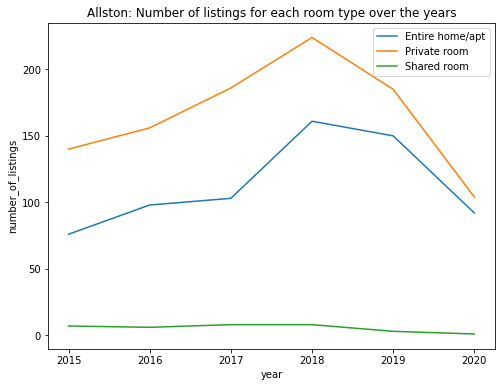

In [89]:
df = pd.DataFrame(room_type_data, index=years)
lines = df.plot.line(figsize=(8,6), title="Allston: Number of listings for each room type over the years")
lines.set_xlabel("year")
lines.set_ylabel("number_of_listings")

We can see from the graph how the number of listings has increased over the years, contributing to the neighbourhoods economy

In [90]:
room_type_data={}
years=[2020,2019,2018,2017,2016,2015]
room_types = ["Entire home/apt", "Private room", "Shared room"]
for room_type in room_types:
    format_data_allston(room_type,'average_price')


Text(0, 0.5, 'average_price')

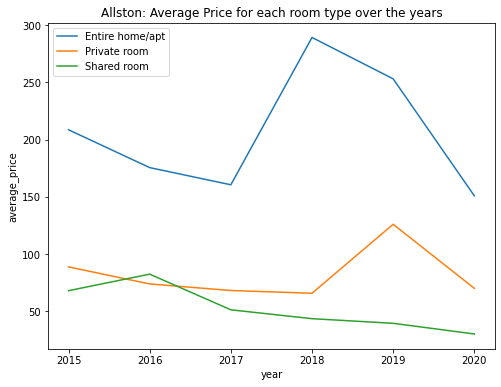

In [91]:
df = pd.DataFrame(room_type_data, index=years)
lines = df.plot.line(figsize=(8,6), title="Allston: Average Price for each room type over the years")
lines.set_xlabel("year")
lines.set_ylabel("average_price")

### Fenway

In [93]:
neighbourhood = "Fenway"
fenway_neighbourhood_2015 = neighbourhood_data_analysis_detailed("data/Boston/2015/October/listings.csv", neighbourhood, 2015)
fenway_neighbourhood_2016 = neighbourhood_data_analysis_detailed("data/Boston/2016/September/listings.csv", neighbourhood, 2016)
fenway_neighbourhood_2017 = neighbourhood_data_analysis_detailed("data/Boston/2017/October/listings.csv", neighbourhood, 2017)
fenway_neighbourhood_2018 = neighbourhood_data_analysis_detailed("data/Boston/2018/July/listings.csv", neighbourhood, 2018)
fenway_neighbourhood_2019 = neighbourhood_data_analysis_detailed("data/Boston/2019/June/listings.csv", neighbourhood, 2019)
fenway_neighbourhood_2020 = neighbourhood_data_analysis_detailed("data/Boston/2020/June/listings_original.csv", neighbourhood, 2020)
fenway_neighbourhood = fenway_neighbourhood_2020.union(fenway_neighbourhood_2019)
fenway_neighbourhood = fenway_neighbourhood.union(fenway_neighbourhood_2018)
fenway_neighbourhood = fenway_neighbourhood.union(fenway_neighbourhood_2017)
fenway_neighbourhood = fenway_neighbourhood.union(fenway_neighbourhood_2016)
fenway_neighbourhood = fenway_neighbourhood.union(fenway_neighbourhood_2015)
fenway_neighbourhood.toPandas()

,room_type,number_of_listings,average_price,year
0,Entire home/apt,142,240.65,2020
1,Private room,23,110.70,2020
2,Shared room,1,750.00,2020
3,Hotel room,1,0.00,2020
4,Entire home/apt,328,258.68,2019
5,Private room,67,124.52,2019
6,Shared room,5,208.00,2019
7,Entire home/apt,399,268.74,2018
8,Private room,90,108.11,2018
9,Shared room,9,151.22,2018


In [94]:
def format_data_fenway(room_type, column_name):
    filter_cond = f"room_type == '{room_type}'".format(room_type = room_type)
    room_type_data[room_type]= fenway_neighbourhood.where(filter_cond).select(column_name).toPandas()[column_name].tolist()

In [95]:
room_type_data={}
years=[2020,2019,2018,2017,2016,2015]
room_types = ["Entire home/apt", "Private room", "Shared room"]
for room_type in room_types:
    format_data_fenway(room_type,'number_of_listings')


Text(0, 0.5, 'number_of_listings')

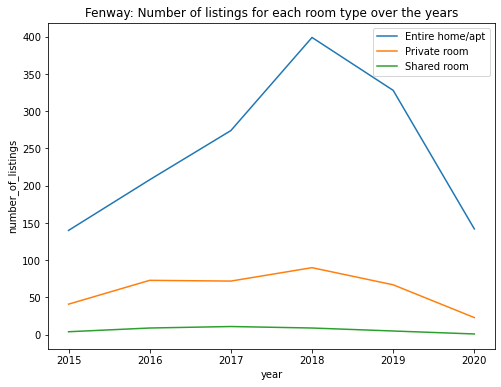

In [96]:
df = pd.DataFrame(room_type_data, index=years)
lines = df.plot.line(figsize=(8,6), title="Fenway: Number of listings for each room type over the years")
lines.set_xlabel("year")
lines.set_ylabel("number_of_listings")

In [97]:
room_type_data={}
years=[2020,2019,2018,2017,2016,2015]
room_types = ["Entire home/apt", "Private room", "Shared room"]
for room_type in room_types:
    format_data_fenway(room_type,'average_price')


Text(0, 0.5, 'average_price')

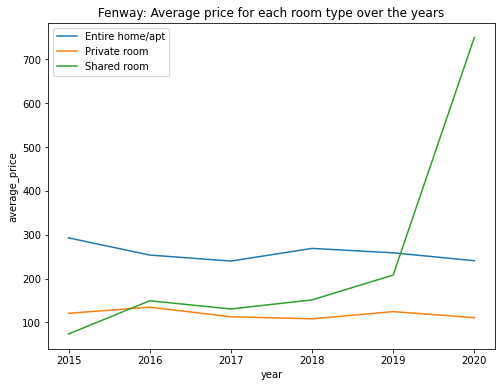

In [98]:
df = pd.DataFrame(room_type_data, index=years)
lines = df.plot.line(figsize=(8,6), title="Fenway: Average price for each room type over the years")
lines.set_xlabel("year")
lines.set_ylabel("average_price")

### Dorchester

In [99]:
neighbourhood = "Dorchester"
dorchester_neighbourhood_2015 = neighbourhood_data_analysis_detailed("data/Boston/2015/October/listings.csv", neighbourhood, 2015)
dorchester_neighbourhood_2016 = neighbourhood_data_analysis_detailed("data/Boston/2016/September/listings.csv", neighbourhood, 2016)
dorchester_neighbourhood_2017 = neighbourhood_data_analysis_detailed("data/Boston/2017/October/listings.csv", neighbourhood, 2017)
dorchester_neighbourhood_2018 = neighbourhood_data_analysis_detailed("data/Boston/2018/July/listings.csv", neighbourhood, 2018)
dorchester_neighbourhood_2019 = neighbourhood_data_analysis_detailed("data/Boston/2019/June/listings.csv", neighbourhood, 2019)
dorchester_neighbourhood_2020 = neighbourhood_data_analysis_detailed("data/Boston/2020/June/listings_original.csv", neighbourhood, 2020)
dorchester_neighbourhood = dorchester_neighbourhood_2020.union(dorchester_neighbourhood_2019)
dorchester_neighbourhood = dorchester_neighbourhood.union(dorchester_neighbourhood_2018)
dorchester_neighbourhood = dorchester_neighbourhood.union(dorchester_neighbourhood_2017)
dorchester_neighbourhood = dorchester_neighbourhood.union(dorchester_neighbourhood_2016)
dorchester_neighbourhood = dorchester_neighbourhood.union(dorchester_neighbourhood_2015)
dorchester_neighbourhood.toPandas()

,room_type,number_of_listings,average_price,year
0,Private room,300,133.87,2020
1,Entire home/apt,118,223.54,2020
2,Hotel room,2,152.00,2020
3,Private room,415,73.57,2019
4,Entire home/apt,137,209.98,2019
5,Shared room,6,71.50,2019
6,Private room,385,69.30,2018
7,Entire home/apt,129,188.72,2018
8,Shared room,5,82.00,2018
9,Private room,290,68.61,2017


In [100]:
def format_data_dorchester(room_type, column_name):
    filter_cond = f"room_type == '{room_type}'".format(room_type = room_type)
    room_type_data[room_type]= dorchester_neighbourhood.where(filter_cond).select(column_name).toPandas()[column_name].tolist()

In [101]:
room_type_data={}
years=[2020,2019,2018,2017,2016,2015]
room_types = ["Entire home/apt", "Private room", "Shared room"]
for room_type in room_types:
    format_data_dorchester(room_type,'number_of_listings')
room_type_data['Shared room'].append(0)

Text(0, 0.5, 'number_of_listings')

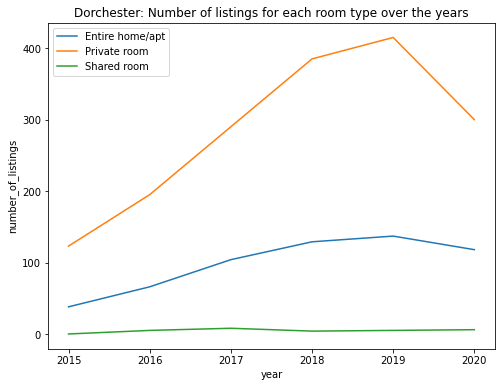

In [102]:
df = pd.DataFrame(room_type_data, index=years)
lines = df.plot.line(figsize=(8,6), title="Dorchester: Number of listings for each room type over the years")
lines.set_xlabel("year")
lines.set_ylabel("number_of_listings")

In [103]:
room_type_data={}
years=[2020,2019,2018,2017,2016,2015]
room_types = ["Entire home/apt", "Private room", "Shared room"]
for room_type in room_types:
    format_data_dorchester(room_type,'average_price')
room_type_data['Shared room'].append(0)

Text(0, 0.5, 'average_price')

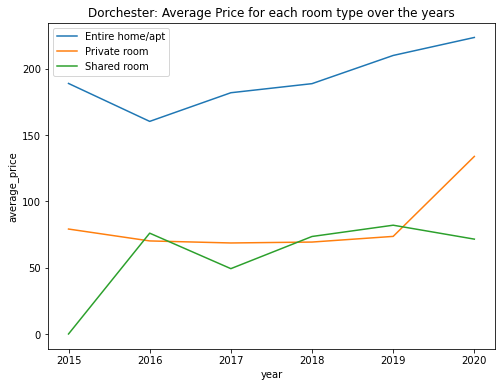

In [104]:
df = pd.DataFrame(room_type_data, index=years)
lines = df.plot.line(figsize=(8,6), title="Dorchester: Average Price for each room type over the years")
lines.set_xlabel("year")
lines.set_ylabel("average_price")